# データ

訓練データセットに含まれるカラムを以下に示します。(テストデータセットにはqualityカラムは含まれません。)

カラム名|説明
---|---
fixed acidity | 酒石酸濃度
volatile acidity | 酢酸濃度
citric acid | クエン酸濃度
residual sugar | 発酵後に残っている砂糖の量
chlorides | ワインに含まれる塩分量
free sulfur dioxide | 遊離二酸化硫黄の量
total sulfur dioxide | (すべての)二酸化硫黄の量
density | ワインの密度
pH | ワインのpH
sulphates | ワインに含まれる硫酸塩の量
alcohol | アルコールの度数
quality | ワインの評価

In [27]:
# common
import math
import datetime
import numpy as np
import scipy as sp
import pandas as pd
from collections import Counter

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# train tool
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
import optuna
from scipy.stats import gaussian_kde

# warning非表示
import warnings
warnings.filterwarnings('ignore')

# 可視化に関する設定
sns.set()
%matplotlib inline

# 小数第3位まで表示
%precision 3

'%.3f'

In [14]:
# URL
path_winequality_dir = r"C:\Users\ko199\python_sv\sandbox\competition2\competition2\input"
train_file_name = "train.csv"
test_file_name = "test.csv"

In [64]:
df_train_raw = pd.read_csv(path_winequality_dir + "\\" + train_file_name)
df_test_raw = pd.read_csv(path_winequality_dir + "\\" + test_file_name)

In [16]:
df_train_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1280.00000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1158.000000,1143.000000,1280.000000,1280.000000,1280.000000
mean,8.34125,0.527187,0.271383,2.549766,0.087614,15.599844,45.652813,0.997019,3.309405,0.658953,10.427812,5.614297
std,1.74115,0.181153,0.194353,1.452651,0.049233,10.482150,32.914044,0.010262,0.158249,0.175200,1.065322,0.987628
min,4.70000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.951600,2.720000,0.330000,8.400000,2.500000
25%,7.10000,0.390000,0.100000,1.900000,0.070000,7.000000,21.675000,0.990300,3.210000,0.550000,9.500000,4.900000
50%,8.00000,0.520000,0.260000,2.200000,0.079000,13.100000,36.800000,0.997350,3.310000,0.620000,10.200000,5.500000
75%,9.30000,0.640000,0.430000,2.600000,0.090250,20.925000,60.350000,1.003500,3.400000,0.730000,11.100000,6.300000
max,15.90000,1.610000,1.000000,15.500000,0.615000,71.800000,290.300000,1.029000,3.970000,2.050000,15.000000,9.700000


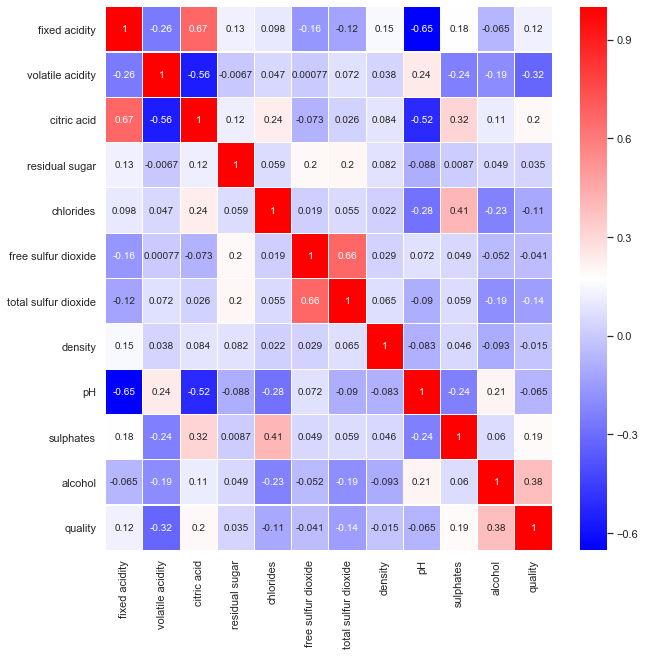

In [336]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(df_train_raw.corr(),annot=True, cmap='bwr',linewidths=0.2, ax=ax) 

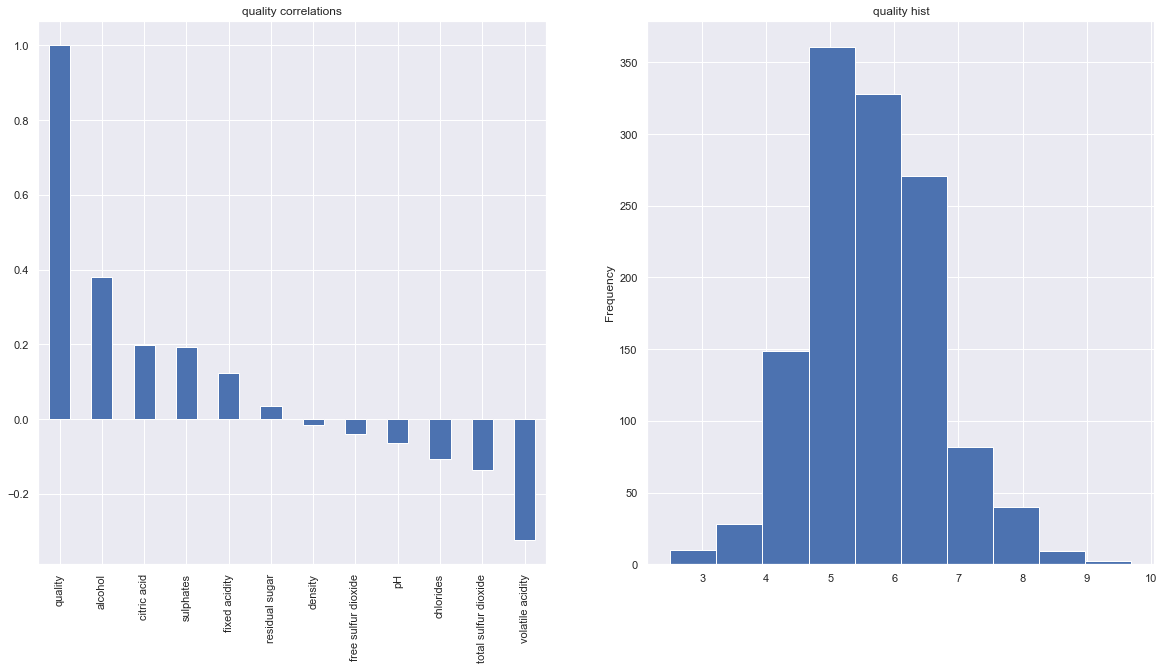

In [337]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

correlations = df_train_raw.corr()['quality'].sort_values(ascending=False)
correlations.plot(kind='bar', ax=axes[0], title="quality correlations")
df_train_raw["quality"].plot(kind="hist", ax=axes[1], title="quality hist")

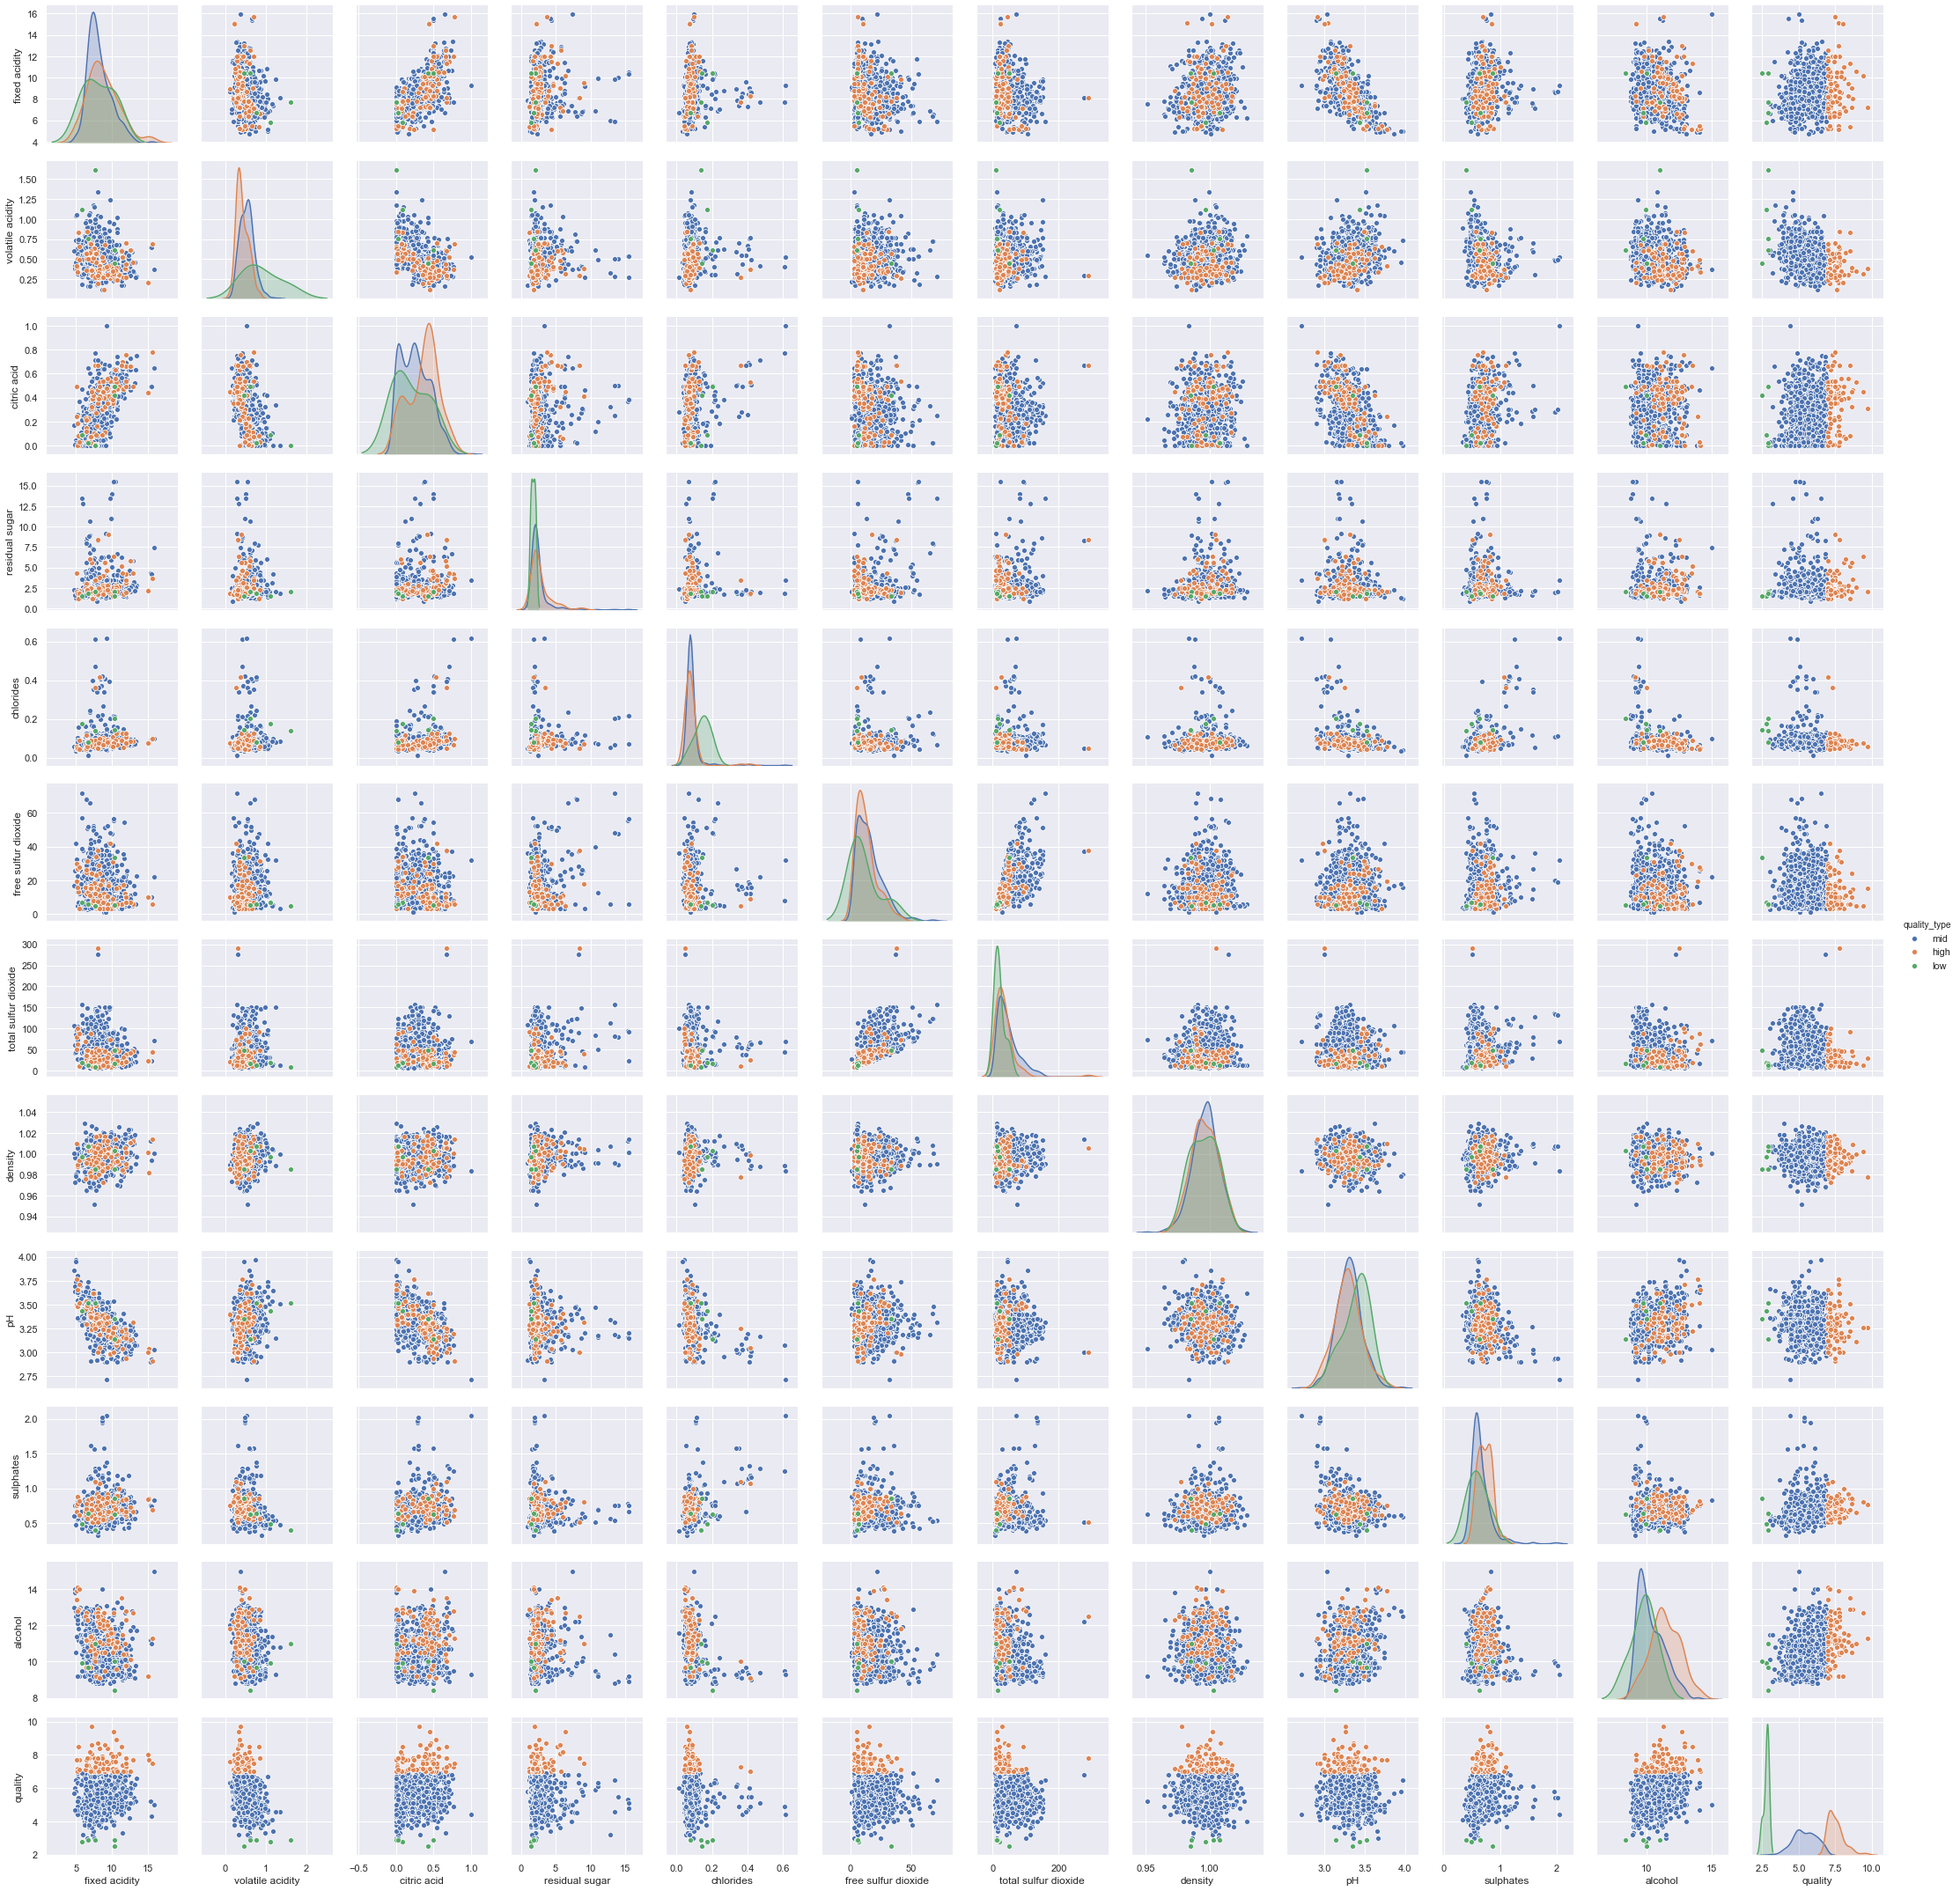

In [338]:
df_train_plot = df_train_raw.dropna().copy()
df_train_plot["quality_type"] = "low"
df_train_plot.loc[df_train_plot["quality"]>=3.0, "quality_type"] = "mid"
df_train_plot.loc[df_train_plot["quality"]>=7.0, "quality_type"] = "high"
sns.pairplot(df_train_plot, hue='quality_type')

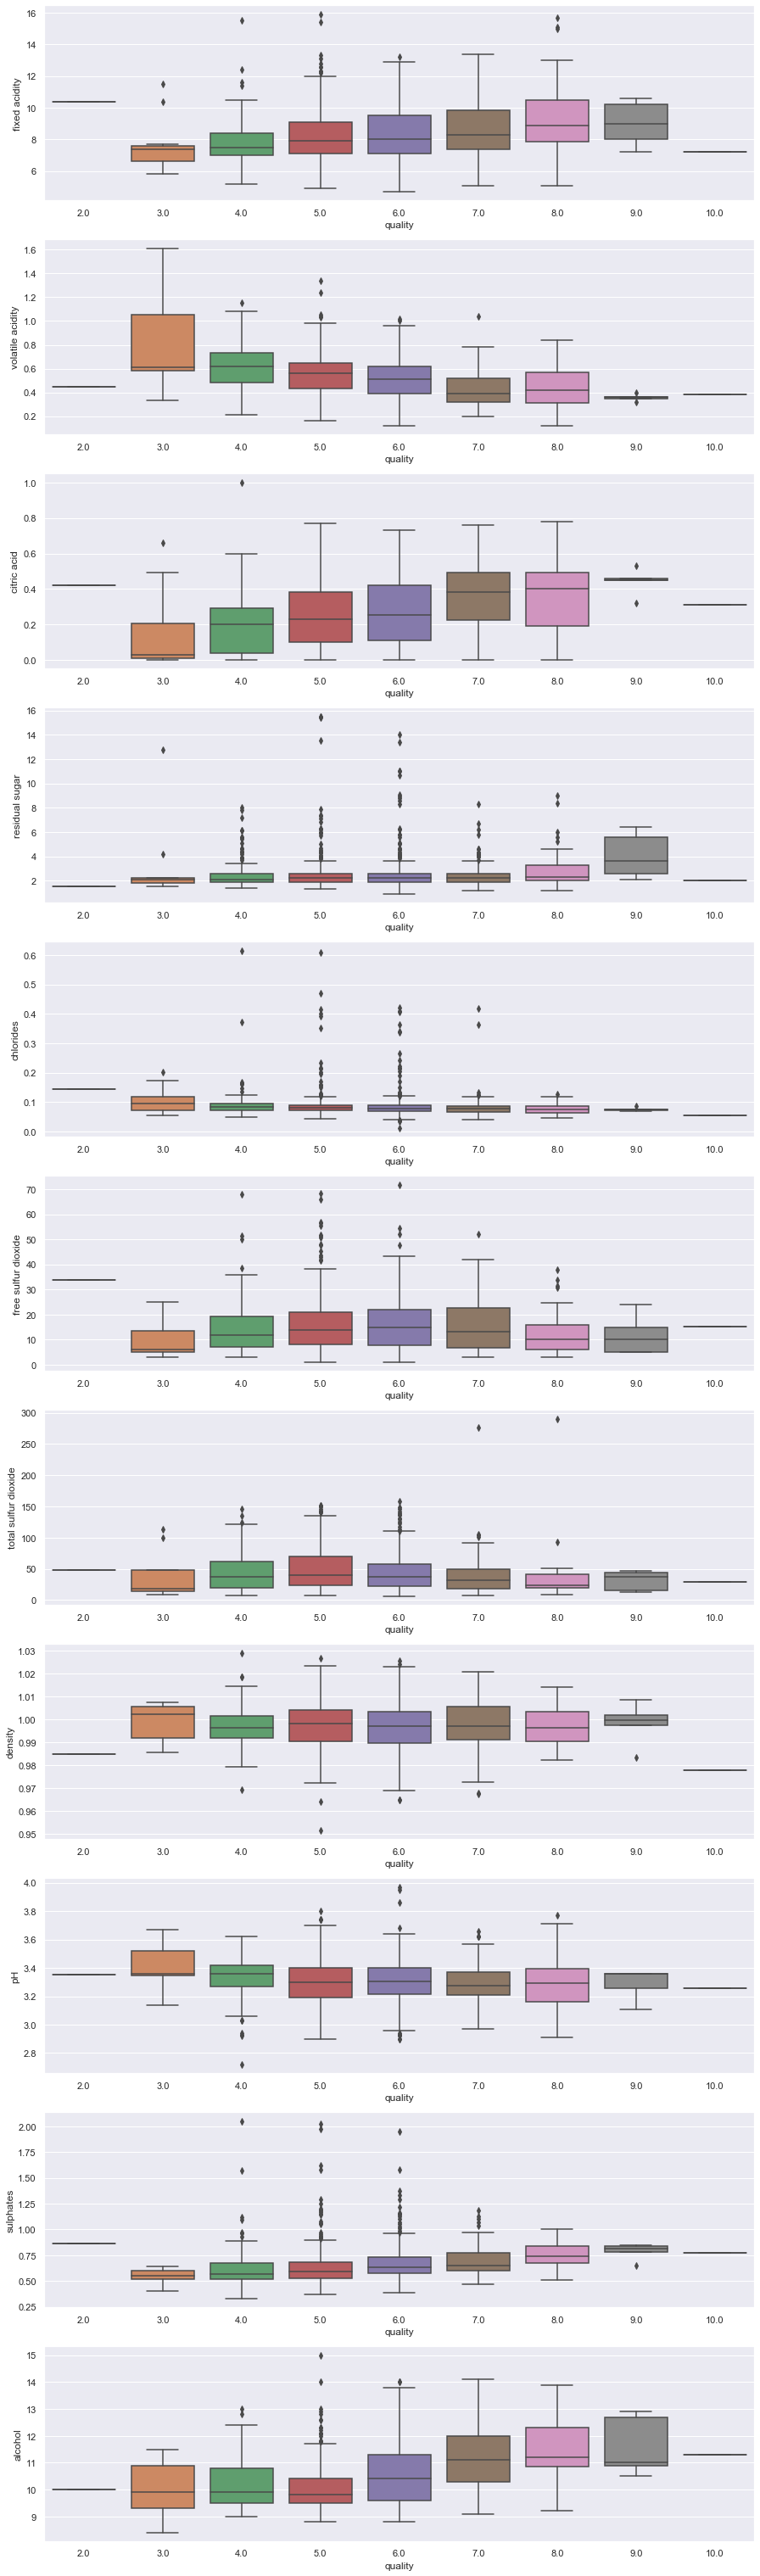

In [28]:
# Box Plot
df_train_box_plot = df_train_plot.copy()
df_train_box_plot["quality"] = df_train_box_plot["quality"].round(0)

columns = df_train_box_plot.drop(["quality", "quality_type"], axis=1).columns
col_len = len(columns)

fig, axes = plt.subplots(nrows=col_len, ncols=1, figsize=(15, 5 * col_len))

for i, col in enumerate(columns):
    bp = sns.boxplot(x='quality',y=col, data=df_train_box_plot, ax=axes[i])

In [54]:
# 欠損値を線形単回帰分析で補完
def fillna_by_reg(df_org):
    df = df_org.copy()
    
    def get_reg(df, ev_column, pv_column):

        target_df = df.dropna(subset=[pv_column])

        # 説明変数
        X = target_df[[ev_column]].values

        # 目的変数
        Y = target_df[pv_column].values

        # 線形回帰のインスタンスを生成
        reg = linear_model.LinearRegression()

        # 予測モデルを計算、ここでa,bを算出
        reg.fit(X, Y)

        # 回帰係数
        #print('回帰係数:', reg.coef_)
        # 切片 
        #print('切片:', reg.intercept_, end="\n\n")

        return reg
    
    isnull_column_list = list(df.isnull().sum()[df.isnull().sum() > 0].index)
#     print("欠損値のある列:", isnull_column_list, end="\n\n")
    
    for isnull_column in isnull_column_list:
    
        pv_column = isnull_column
        corr = df.corr()[pv_column].abs()
        corr.drop(isnull_column_list, inplace=True)
        ev_column =  list(corr[corr == corr.max()].index)[0]

        #print("説明変数:", ev_column)
        #print("目的変数:", pv_column, end="\n\n")

        reg = get_reg(df, ev_column, pv_column)
        df.loc[df[isnull_column].isnull(), isnull_column] = reg.predict(df.loc[df[isnull_column].isnull(),[ev_column]].values)

    #print("null値の数", df.isnull().sum().sum(), end="\n\n")
    
    return df

In [55]:
def ommit_outlier(df_org, min_q=None, max_q=None):
    
    df = df_org.copy()
    
    print("外れ値除去実行前の行数:", len(df))
    
    if "quality" in list(df.columns):
        columns_list = list(df.drop("quality", axis=1).columns)
    else:
        columns_list = list(df.columns)

    low_val = 0
    high_val = 9999
        
    for column in columns_list:

        if min_q is None or max_q is None:
            # 扱うデータの最小値・最大値
            iqr = df[column].quantile(q=0.75) - df[column].quantile(q=0.25)
            low_val = df[column].quantile(q=0.25) - (1.5 * iqr)
            high_val = df[column].quantile(q=0.75) + (1.5 * iqr)
        else:
            low_val = df[column].quantile(q=min_q)
            high_val = df[column].quantile(q=max_q)

        # 最小値・最大値のデータに範囲を絞る
        df = df[(df[column]>=low_val) & (df[column]<=high_val)]

    print("外れ値除去実行後の行数:", len(df), end="\n\n")
        
    return df

In [872]:
def column_organize(df_org):
    
    df = df_org.copy()
    
    df["free sulfur dioxide"] = df["free sulfur dioxide"] / 100
    df["total sulfur dioxide"] = df["total sulfur dioxide"] / 100
    
#     df["free sulfur dioxide ratio"] = 100 * df["free sulfur dioxide"] / df["total sulfur dioxide"]
    
    del_target_columns =[
#         "fixed acidity", 
#         "citric acid", 
#         "total sulfur dioxide", 
#         "free sulfur dioxide", 
#         "volatile acidity",
#         "density",
#         "residual sugar",
#         "chlorides",
#         "sulphates",
        "pH"
    ]
    df.drop(del_target_columns, axis=1, inplace=True)
    
    return df

In [873]:
def select_high_corr(df, min_corr):
    ser_corr = df.corr()["quality"].abs()
    ser_corr = ser_corr[ser_corr > min_corr]
    high_corr_list = list(ser_corr.index)
#     print(ser_corr)
    
    df = df[high_corr_list]
    
    return df

In [874]:
def standard(df_org):
    df = df_org.copy()
    
    target_columns = list(df.columns)
    if "quality" in target_columns:
        target_columns.remove("quality")
        
        df = df[target_columns]
    
    sc = StandardScaler()
    std_list = sc.fit_transform(df)
    
    for i, column in enumerate(target_columns):
        df[column] = std_list.T[i]
    
    return df

In [875]:
def best_modeling(X, y, params):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    
    regressor_name = params["regressor"]
    
    if regressor_name == "xgb":

        ml_model = xgb_modeling(X, y)

    elif regressor_name == "RandomForestRegressor":
        rfr_tuna = RandomForestRegressor(
            criterion='mse',
            max_depth=params["max_depth"],
            min_samples_leaf=params["min_samples_leaf"], 
            n_estimators=100, 
            n_jobs=-1, 
            random_state=42
        )

        rfr_tuna.fit(X_train, y_train)
        ml_model = rfr_tuna
        
    elif regressor_name == "LinearRegression":
        # 線形回帰のインスタンスを生成
        lr_tuna = linear_model.LinearRegression()

        # 予測モデルを計算
        lr_tuna.fit(X_train, y_train)
        ml_model = lr_tuna

    elif regressor_name == "MLPRegressor":
        hidden_layer_size = params["hidden_layer_size"]
        
        mlpr_tuna = MLPRegressor(hidden_layer_sizes=(hidden_layer_size,hidden_layer_size,hidden_layer_size), random_state=42)
        mlpr_tuna.fit(X_train, y_train)
        ml_model = mlpr_tuna

    elif regressor_name == "SVR":
        svr_tuna = SVR()
        svr_tuna.fit(X_train, y_train)
        ml_model = svr_tuna


    if regressor_name == "xgb":
        # 予測
        dtest = xgb.DMatrix(X_valid, label=y_valid)
        tuna_pred_valid = ml_model.predict(dtest)
    else:
        # 予測
        tuna_pred_valid = ml_model.predict(X_valid)


    return ml_model, mean_squared_error(y_valid, tuna_pred_valid)

In [876]:
def modeling_optuna(X, y, n_trials):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
    
    def ml_opt(trial):
        
        regressor_name = trial.suggest_categorical('regressor', ['SVR', 'MLPRegressor', "LinearRegression", "RandomForestRegressor", "xgb"])
        
        if regressor_name == "xgb":

            ml_model = xgb_modeling(X, y)

        elif regressor_name == "RandomForestRegressor":
            
            max_depth = trial.suggest_int('max_depth', 1, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
            
            rfr_tuna = RandomForestRegressor(
                criterion='mse',
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf, 
                n_estimators=100, 
                n_jobs=-1, 
                random_state=42
            )

            rfr_tuna.fit(X_train, y_train)
            ml_model = rfr_tuna
        
        elif regressor_name == "LinearRegression":
            # 線形回帰のインスタンスを生成
            lr_tuna = linear_model.LinearRegression()

            # 予測モデルを計算
            lr_tuna.fit(X_train, y_train)
            ml_model = lr_tuna
        
        elif regressor_name == "MLPRegressor":
            hidden_layer_size = trial.suggest_int('hidden_layer_size', 5, 10)
            
            mlpr_tuna = MLPRegressor(hidden_layer_sizes=(hidden_layer_size,hidden_layer_size,hidden_layer_size), random_state=42)
            mlpr_tuna.fit(X_train, y_train)
            ml_model = mlpr_tuna
        
        elif regressor_name == "SVR":
            svr_tuna = SVR()
            svr_tuna.fit(X_train, y_train)
            ml_model = svr_tuna

            
        if regressor_name == "xgb":
            # 予測
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_valid, label=y_valid)
            tuna_pred_valid = ml_model.predict(dtest)
            
            mean_squared_error_train = mean_squared_error(ml_model.predict(dtrain), y_train)
            mean_squared_error_valid = mean_squared_error(tuna_pred_valid, y_valid)
            print(regressor_name)
            print('Train MSE: ', mean_squared_error_train)
            print(' Test MSE: ', mean_squared_error_valid)            
        else:
            # 予測
            tuna_pred_valid = ml_model.predict(X_valid)
            
            mean_squared_error_train = mean_squared_error(ml_model.predict(X_train), y_train)
            mean_squared_error_valid = mean_squared_error(tuna_pred_valid, y_valid)
            print(regressor_name)
            print('Train MSE: ', mean_squared_error_train)
            print(' Test MSE: ', mean_squared_error_valid)
            
        return abs(mean_squared_error_train - mean_squared_error_valid)
    
    # optuna studyオブジェクト作成
    study = optuna.create_study()
    
    # 最適化の実行
    study.optimize(ml_opt, n_trials=n_trials)
    
    # 最適パラメータの表示
    print("==== 最適パラメータ ====")
    print(study.best_params, end="\n\n")
    
    # 最小化された目的関数を表示
    print("==== 最小化された目的関数 ====")
    print(study.best_value, end="\n\n")
    
    return study.best_params.copy()

In [877]:
def xgb_modeling(X, y):

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)

    evals = [(dtrain, 'train'), (dtest, 'eval')]
    
    xgb_params = {
        'booster': 'gblinear',
        # 回帰問題
        'objective': 'reg:squarederror',
        # 学習用の指標 (RMSE)
        'eval_metric': 'rmse',
        'seed': 42
    }

#     best_params = xgbr_modeling_optuna(X, y, 100)
#     xgb_params.update(best_params)

    evals_result = {}
    num_round = 10000

    bst = xgb.train(
        xgb_params, 
        dtrain, 
        num_boost_round=num_round, 
        evals=evals, 
        evals_result=evals_result, 
        early_stopping_rounds=20, 
        verbose_eval=False
    )

    y_pred = bst.predict(dtest)
    mse = mean_squared_error(y_valid, y_pred)
#     print("train-rmse:", evals_result["train"]["rmse"][-1], "eval-rmse:", evals_result["eval"]["rmse"][-1])
#     print('MSE:', mse, '/', 'RMSE:', math.sqrt(mse))
    
    
    return bst

In [893]:
TEST_SIZE = 0.25

df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

df_train = fillna_by_reg(df_train)
df_test = fillna_by_reg(df_test)

df_train = column_organize(df_train)
df_test = column_organize(df_test)

df_train = ommit_outlier(df_train)

df_train_std = standard(df_train)
df_train_std["quality"] = df_train["quality"]
df_train = df_train_std
df_test = standard(df_test)

df_train = select_high_corr(df_train, 0.05)
df_test = df_test[list(df_train.drop("quality", axis=1).columns)]

df_train.describe()

外れ値除去実行前の行数: 1280
外れ値除去実行後の行数: 932



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,sulphates,alcohol,quality
count,9.320000e+02,9.320000e+02,9.320000e+02,9.320000e+02,9.320000e+02,9.320000e+02,9.320000e+02,9.320000e+02,932.000000
mean,1.648657e-16,3.468851e-16,1.848783e-16,-3.811925e-17,8.729307e-16,-1.124518e-16,1.042561e-15,-9.548871e-16,5.630794
std,1.000537e+00,1.000537e+00,1.000537e+00,1.000537e+00,1.000537e+00,1.000537e+00,1.000537e+00,1.000537e+00,0.950033
min,-2.257186e+00,-2.416022e+00,-1.356208e+00,-2.877096e+00,-2.565570e+00,-1.401669e+00,-2.645950e+00,-1.615887e+00,2.900000
25%,-7.154982e-01,-7.879585e-01,-9.214749e-01,-6.226371e-01,-6.383481e-01,-7.628626e-01,-7.066964e-01,-8.129509e-01,5.000000
50%,-2.016022e-01,-4.075982e-03,-5.200934e-02,-1.717453e-01,4.059082e-03,-2.487017e-01,-1.778091e-01,-2.107491e-01,5.600000
75%,5.692419e-01,6.592092e-01,8.174562e-01,5.045925e-01,6.464663e-01,4.950139e-01,6.155220e-01,6.925536e-01,6.300000
max,2.817537e+00,2.950558e+00,2.610729e+00,3.209944e+00,2.787824e+00,2.911051e+00,2.731071e+00,2.900627e+00,9.700000


In [894]:
X = df_train.drop(["quality"], axis=1)
y = df_train["quality"]

In [895]:
best_params = modeling_optuna(X, y, 10)

SVR
Train MSE:  0.5207105892972956
 Test MSE:  0.6707841595211059


[I 2020-02-02 03:07:15,882] Finished trial#0 resulted in value: 0.1500735702238103. Current best value is 0.1500735702238103 with parameters: {'regressor': 'SVR'}.


RandomForestRegressor
Train MSE:  0.31678254362042885
 Test MSE:  0.6446795385849886


[I 2020-02-02 03:07:17,076] Finished trial#1 resulted in value: 0.32789699496455976. Current best value is 0.1500735702238103 with parameters: {'regressor': 'SVR'}.


SVR
Train MSE:  0.5207105892972956
 Test MSE:  0.6707841595211059


[I 2020-02-02 03:07:18,439] Finished trial#2 resulted in value: 0.1500735702238103. Current best value is 0.1500735702238103 with parameters: {'regressor': 'SVR'}.


MLPRegressor
Train MSE:  0.8195140639574748
 Test MSE:  0.9085087417594964


[I 2020-02-02 03:07:20,010] Finished trial#3 resulted in value: 0.08899467780202153. Current best value is 0.08899467780202153 with parameters: {'regressor': 'MLPRegressor', 'hidden_layer_size': 7}.


xgb
Train MSE:  0.68229243034256
 Test MSE:  0.6851383123298898


[I 2020-02-02 03:07:20,684] Finished trial#4 resulted in value: 0.0028458819873297125. Current best value is 0.0028458819873297125 with parameters: {'regressor': 'xgb'}.


LinearRegression
Train MSE:  0.6822877282921255
 Test MSE:  0.685082405417457


[I 2020-02-02 03:07:21,491] Finished trial#5 resulted in value: 0.002794677125331546. Current best value is 0.002794677125331546 with parameters: {'regressor': 'LinearRegression'}.


SVR
Train MSE:  0.5207105892972956
 Test MSE:  0.6707841595211059


[I 2020-02-02 03:07:22,243] Finished trial#6 resulted in value: 0.1500735702238103. Current best value is 0.002794677125331546 with parameters: {'regressor': 'LinearRegression'}.


xgb
Train MSE:  0.68229243034256
 Test MSE:  0.6851383123298898


[I 2020-02-02 03:07:23,095] Finished trial#7 resulted in value: 0.0028458819873297125. Current best value is 0.002794677125331546 with parameters: {'regressor': 'LinearRegression'}.


RandomForestRegressor
Train MSE:  0.4454616633328011
 Test MSE:  0.6567899765202995


[I 2020-02-02 03:07:24,524] Finished trial#8 resulted in value: 0.21132831318749834. Current best value is 0.002794677125331546 with parameters: {'regressor': 'LinearRegression'}.


LinearRegression
Train MSE:  0.6822877282921255
 Test MSE:  0.685082405417457


[I 2020-02-02 03:07:25,229] Finished trial#9 resulted in value: 0.002794677125331546. Current best value is 0.002794677125331546 with parameters: {'regressor': 'LinearRegression'}.


==== 最適パラメータ ====
{'regressor': 'LinearRegression'}

==== 最小化された目的関数 ====
0.002794677125331546



In [896]:
ml_model, mse = best_modeling(X, y, best_params)

print(best_params)
print("MSE:", mse)

if best_params["regressor"] == "xgb":
    # 予測
    pred = ml_model.predict(xgb.DMatrix(df_test))
else:
    # 予測
    pred = ml_model.predict(df_test)


{'regressor': 'LinearRegression'}
MSE: 0.685082405417457


In [897]:
df_test_quality = df_test.copy()
df_test_quality["quality"]=pd.Series(list(pred))

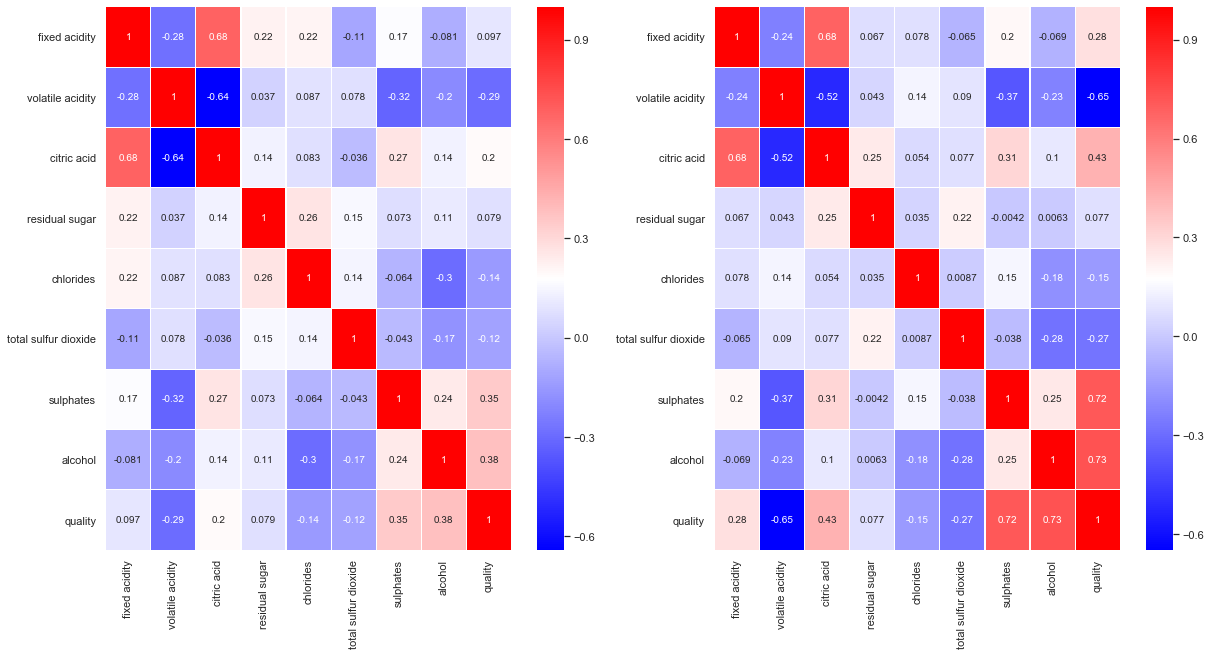

In [898]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.heatmap(df_train[df_test_quality.columns].corr(),annot=True,cmap='bwr',linewidths=0.2, ax=axes[0]) 
sns.heatmap(df_test_quality.corr(),annot=True,cmap='bwr',linewidths=0.2, ax=axes[1]) 

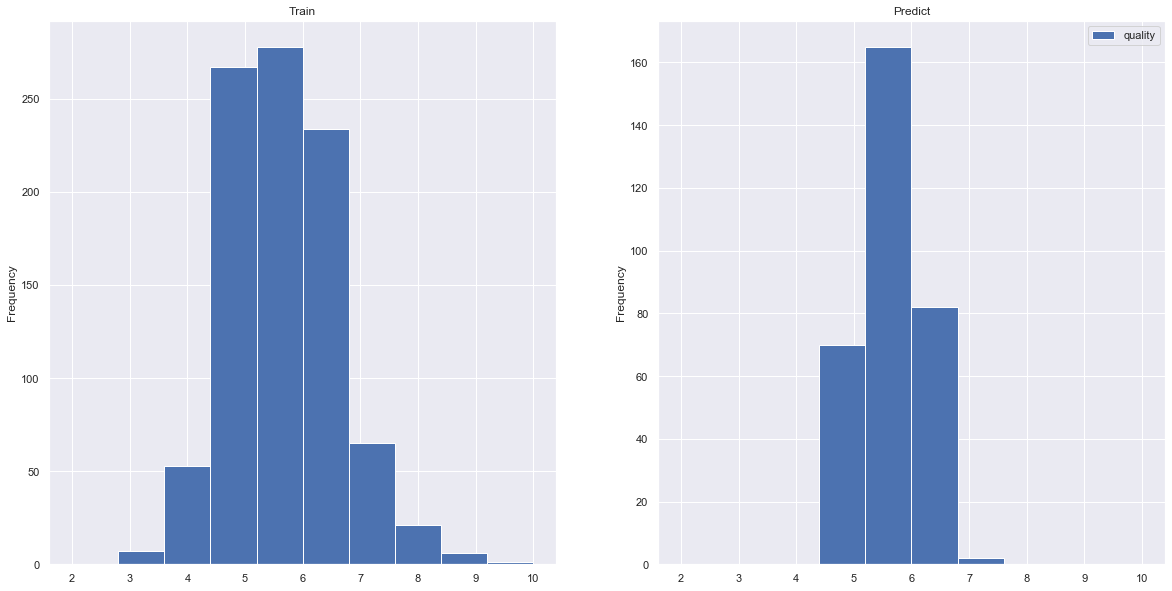

In [899]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# 学習データ
df_train["quality"].plot(kind="hist", ax=axes[0], title="Train", bins=10, range=(2, 10))

# テストデータ
pd.DataFrame({"quality": list(pred)}).plot(kind="hist" , ax=axes[1], title="Predict", bins=10, range=(2, 10))

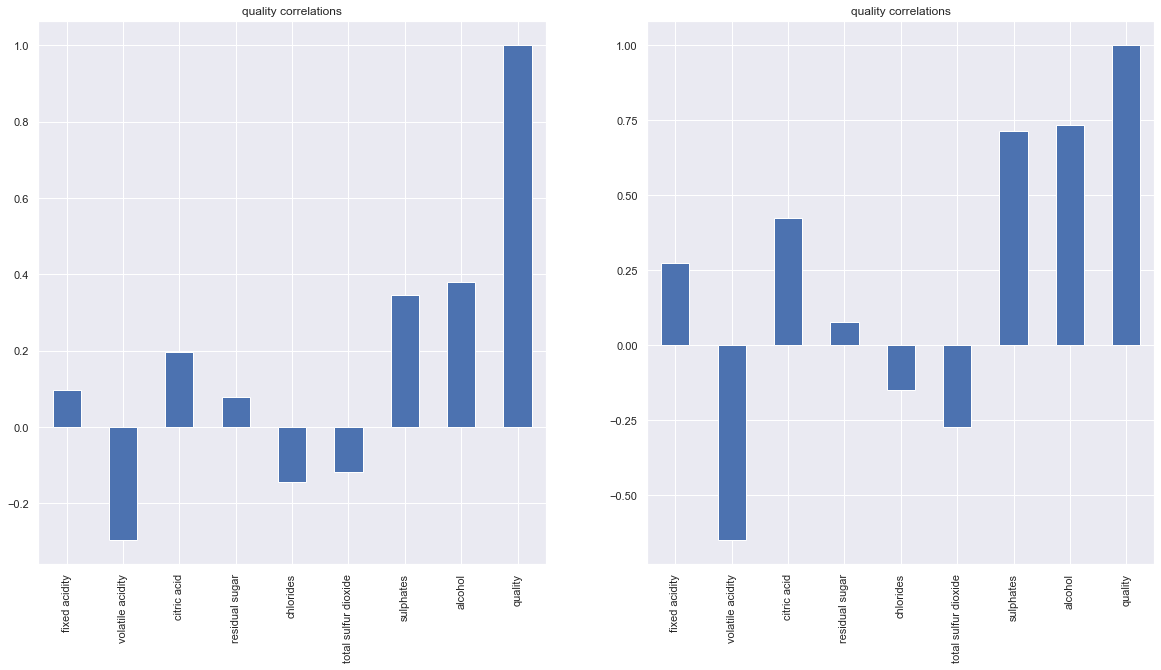

In [900]:
df_test_plot = df_test.copy()
df_test_plot["quality"]=pd.Series(list(pred))
df_test_plot = df_test_plot[list(df_train.columns)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
correlations_train = df_train.corr()['quality']
correlations_train.plot(kind='bar', ax=axes[0], title="quality correlations")
correlations_test = df_test_plot.corr()['quality']
correlations_test.plot(kind='bar', ax=axes[1], title="quality correlations")
# sns.heatmap(df_train.corr(),annot=True,cmap='bwr',linewidths=0.2, ax=axes[0])
# sns.heatmap(df_test_plot.corr(),annot=True,cmap='bwr',linewidths=0.2, ax=axes[1])

In [901]:
df_pred = pd.DataFrame({
    "quality": list(pred)
})
df_pred["quality"]= df_pred["quality"].round(3)
df_pred

,quality
0,5.940
1,5.877
2,5.588
3,6.159
4,6.012
...,...
314,6.997
315,4.816
316,5.470
317,5.153


In [902]:
now_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
now_str

'20200202030951'

In [903]:
output = r"C:\Users\ko199\python_sv\sandbox\competition2\competition2\output\submission_" + now_str + ".csv"
df_pred.to_csv(output, index=False)